## PREDICTION HOUSE PRICES WITH XGBoost REGRESSION

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home. https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### LOADING TRAIN DATASET

In [2]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## REVIEWING MISSING VALUES

In [3]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


#### Columns with missing value more than 10%

In [4]:
missing=df_train.isnull().sum()
missing = missing[missing > 0.1*len(df_train.index)]   
missing   #kayıp veri sayısının %10 dan fazla olduğu sütunlar

LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

#### Columns with missing value more than 10% eliminated.

In [5]:
df_train1=df_train.drop(columns=missing.index) #Columns with more than 10% missing data were eliminated
df_train1

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### Reviewing Dataset

In [6]:
df_train1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [7]:
# Label encoding for categoricals
X = df_train1.copy()
#X = X.drop("Id")
y = X.pop('SalePrice')

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [8]:
X.drop('Id', inplace=True, axis=1)

#### Imputing missing values

In [9]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(X[['MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']])
X[['MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']] = imputer.transform(X[['MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']])

In [10]:
df_train2= pd.concat([X, y], axis=1)
df_train2

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,8450,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,20,0,9600,0,0,0,0,1,0,1,...,0,0,0,0,0,5,2007,0,0,181500
2,60,0,11250,0,1,0,0,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,70,0,9550,0,1,0,0,2,0,2,...,272,0,0,0,0,2,2006,0,1,140000
4,60,0,14260,0,1,0,0,1,0,3,...,0,0,0,0,0,12,2008,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,0,7917,0,0,0,0,0,0,17,...,0,0,0,0,0,8,2007,0,0,175000
1456,20,0,13175,0,0,0,0,0,0,6,...,0,0,0,0,0,2,2010,0,0,210000
1457,70,0,9042,0,0,0,0,0,0,2,...,0,0,0,0,2500,5,2010,0,0,266500
1458,20,0,9717,0,0,0,0,0,0,11,...,112,0,0,0,0,4,2010,0,0,142125


## PRODUCING OF CORRELATION MATRICE AND VISUALIZATION

In [11]:
# Function for making mi_scores
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
    X = X.copy()
    for colname in X.select_dtypes(['object' , 'category']):
        X[colname] , _= X[colname].factorize()
     # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X , y , discrete_features = discrete_features , random_state = 0)
    mi_scores = pd.Series(mi_scores , name = 'MI Scores' , index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

# Function for plotting mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width , scores)
    plt.yticks(width ,  ticks)
    plt.title('Mutual Information Scores')

In [12]:
# Calling make_mi_score
mi_scores = make_mi_scores(X,y)

mi_scores

OverallQual     5.730118e-01
Neighborhood    5.283058e-01
GarageArea      5.003220e-01
GrLivArea       4.318108e-01
YearBuilt       4.098500e-01
                    ...     
Street          6.224335e-04
Utilities       1.887379e-15
PoolArea        2.220446e-16
MoSold          0.000000e+00
YrSold          0.000000e+00
Name: MI Scores, Length: 73, dtype: float64

OverallQual     0.573012
Neighborhood    0.528306
GarageArea      0.500322
GrLivArea       0.431811
YearBuilt       0.409850
TotalBsmtSF     0.395540
LotArea         0.391073
GarageCars      0.365232
ExterQual       0.335218
BsmtQual        0.328262
KitchenQual     0.323719
GarageYrBlt     0.291568
MSSubClass      0.282817
1stFlrSF        0.280714
YearRemodAdd    0.276189
FullBath        0.262372
GarageFinish    0.254456
TotRmsAbvGrd    0.219135
Foundation      0.209538
GarageType      0.207246
Name: MI Scores, dtype: float64


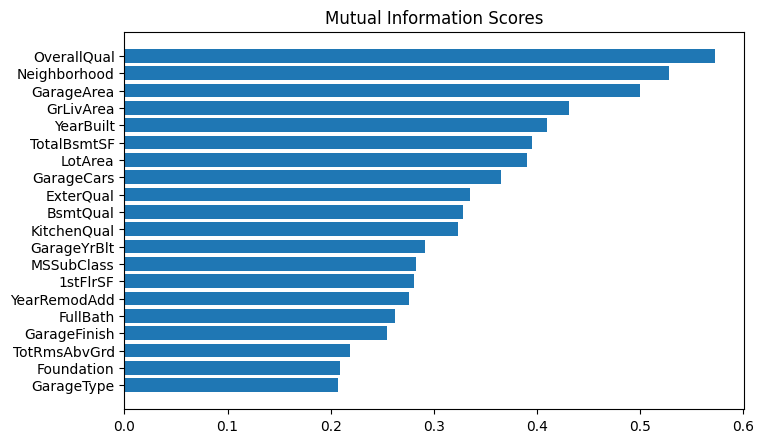

In [13]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

Features 

In [14]:
df_train2["SqFtPerRoom"] = df_train2["GrLivArea"] / (df_train2["TotRmsAbvGrd"] +
                                                       df_train2["FullBath"] +
                                                       df_train2["HalfBath"] +
                                                       df_train2["KitchenAbvGr"])

df_train2['Total_Home_Quality'] = df_train2['OverallQual'] + df_train2['OverallCond']

df_train2['Total_Bathrooms'] = (df_train2['FullBath'] + (0.5 * df_train2['HalfBath']) +
                               df_train2['BsmtFullBath'] + (0.5 * df_train2['BsmtHalfBath']))

In [15]:
df_train2

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms
0,60,0,8450,0,0,0,0,0,0,0,...,0,0,2,2008,0,0,208500,142.500000,12,3.5
1,20,0,9600,0,0,0,0,1,0,1,...,0,0,5,2007,0,0,181500,140.222222,14,2.5
2,60,0,11250,0,1,0,0,0,0,0,...,0,0,9,2008,0,0,223500,178.600000,12,3.5
3,70,0,9550,0,1,0,0,2,0,2,...,0,0,2,2006,0,1,140000,190.777778,12,2.0
4,60,0,14260,0,1,0,0,1,0,3,...,0,0,12,2008,0,0,250000,169.076923,13,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,0,7917,0,0,0,0,0,0,17,...,0,0,8,2007,0,0,175000,149.727273,11,2.5
1456,20,0,13175,0,0,0,0,0,0,6,...,0,0,2,2010,0,0,210000,207.300000,12,3.0
1457,70,0,9042,0,0,0,0,0,0,2,...,0,2500,5,2010,0,0,266500,195.000000,16,2.0
1458,20,0,9717,0,0,0,0,0,0,11,...,0,0,4,2010,0,0,142125,154.000000,11,2.0


In [16]:
corrmat = df_train2.corr() # extracting the correlation matrix between numerical data. correlation matrix is numerical only
corrmat                   

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms
MSSubClass,1.000000,0.286937,-0.139781,0.024969,-0.115361,-0.018947,-0.022844,-0.069160,-0.025672,0.181163,...,0.008283,-0.007683,-0.013585,-0.021407,0.012874,-0.015047,-0.084284,0.001050,-0.012331,0.151048
MSZoning,0.286937,1.000000,-0.161640,0.039678,-0.167918,-0.013396,-0.011167,-0.094747,-0.043444,-0.067889,...,-0.029301,-0.021573,0.022231,-0.010621,0.058948,0.068705,-0.116047,-0.042087,-0.030066,-0.071795
LotArea,-0.139781,-0.161640,1.000000,0.197131,0.315484,0.258792,0.010123,0.160976,0.436868,0.043191,...,0.077672,0.038068,0.001205,-0.014261,-0.013882,0.000199,0.263843,0.260667,0.082701,0.204764
Street,0.024969,0.039678,0.197131,1.000000,0.010129,0.097236,-0.001682,0.004458,0.179360,0.053445,...,-0.004413,0.022733,-0.003690,0.025043,0.021171,0.022919,-0.041036,-0.018968,-0.076192,-0.010414
LotShape,-0.115361,-0.167918,0.315484,0.010129,1.000000,0.201047,0.026616,0.308073,0.144248,-0.013295,...,0.047100,0.028638,0.026617,-0.037391,0.001435,-0.004773,0.267759,0.177514,0.140331,0.218018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition,-0.015047,0.068705,0.000199,0.022919,-0.004773,0.062826,0.019173,-0.013638,0.017187,0.007101,...,0.068578,-0.032655,0.054679,-0.123720,0.232149,1.000000,0.142503,0.013393,0.012421,0.078508
SalePrice,-0.084284,-0.116047,0.263843,-0.041036,0.267759,0.092009,-0.014314,0.109106,0.051152,-0.143621,...,0.092404,-0.021190,0.046432,-0.028923,0.072896,0.142503,1.000000,0.566461,0.594786,0.631731
SqFtPerRoom,0.001050,-0.042087,0.260667,-0.018968,0.177514,0.091780,-0.007419,0.116691,0.146329,-0.070500,...,0.160764,-0.029214,0.062222,-0.025458,0.021721,0.013393,0.566461,1.000000,0.379312,0.353340
Total_Home_Quality,-0.012331,-0.030066,0.082701,-0.076192,0.140331,0.032606,0.005031,0.070249,-0.047461,-0.152583,...,0.051913,0.019545,0.055523,0.006547,-0.021332,0.012421,0.594786,0.379312,1.000000,0.327497


<AxesSubplot:>

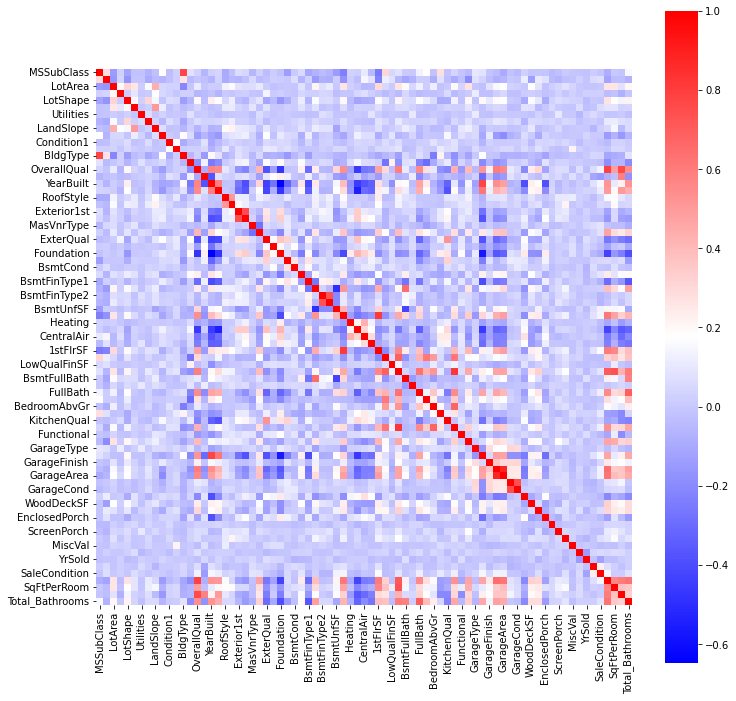

In [17]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,square=True,cmap="bwr" )

#### Slicing of columns which correlation>0.5 with SalePrice

In [18]:
corrSale=corrmat[corrmat["SalePrice"]>0.5] # Detection of columns with a correlation greater than 0.5 with the selling price
corrSale

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms
OverallQual,0.032628,-0.015122,0.105806,-0.058823,0.198994,0.039133,-0.001881,0.060576,-0.066450,-0.138913,...,0.065166,-0.031406,0.070815,-0.027347,0.063406,0.131870,0.790982,0.486107,0.756229,0.541063
YearBuilt,0.027850,-0.062684,0.014228,-0.021137,0.229365,-0.029314,-0.011505,0.033011,-0.073639,-0.115600,...,0.004950,-0.034383,0.012398,-0.013618,0.077768,0.149704,0.522897,0.107450,0.220325,0.524298
YearRemodAdd,0.040581,0.033050,0.013788,-0.065465,0.175488,-0.007847,-0.034080,0.042451,-0.059105,-0.155964,...,0.005829,-0.010286,0.021490,0.035743,0.031197,0.117656,0.507101,0.199278,0.498164,0.443719
TotalBsmtSF,-0.238518,-0.175826,0.260833,-0.005068,0.200469,0.056286,-0.014233,0.061572,0.032498,-0.113269,...,0.126053,-0.018479,0.013196,-0.014969,0.082509,0.142533,0.613581,0.475744,0.326768,0.414468
1stFlrSF,-0.251758,-0.227642,0.299475,-0.005950,0.189251,0.069659,0.012287,0.083254,0.068323,-0.086958,...,0.131525,-0.021096,0.031372,-0.013604,0.083203,0.166194,0.605852,0.563451,0.294148,0.390557
GrLivArea,0.074853,-0.061209,0.263116,-0.044121,0.212741,0.055967,-0.008545,0.099722,0.043860,-0.058901,...,0.170205,-0.002416,0.050240,-0.036526,0.033941,0.092110,0.708624,0.734558,0.431911,0.595169
FullBath,0.131608,0.011160,0.126031,-0.046471,0.184213,-0.003962,-0.026862,0.028106,-0.046936,-0.061679,...,0.049604,-0.014290,0.055872,-0.019669,0.043578,0.123659,0.560664,0.294337,0.322066,0.694197
TotRmsAbvGrd,0.040380,-0.089983,0.190015,-0.046828,0.137148,0.021954,0.007769,0.050913,-0.033768,-0.008988,...,0.083757,0.024763,0.036907,-0.034516,0.040563,0.118449,0.533723,0.294144,0.311236,0.460273
GarageCars,-0.040110,-0.077273,0.154871,0.020025,0.194984,0.049099,0.008161,0.092441,-0.002683,-0.151207,...,0.020934,-0.043080,0.040522,-0.039117,0.019239,0.132221,0.640409,0.347884,0.368470,0.483578
GarageArea,-0.098672,-0.057814,0.180403,0.047794,0.173472,0.040419,0.006372,0.083666,0.004826,-0.195227,...,0.061047,-0.027400,0.027974,-0.027378,0.037023,0.127422,0.623431,0.391998,0.359404,0.451567


In [19]:
corrSale.index # Names of columns with a correlation greater than 0.5 with sales price

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice', 'SqFtPerRoom', 'Total_Home_Quality', 'Total_Bathrooms'],
      dtype='object')

#### New dataset built with columns which correlation>0.5 with SalePrice

In [20]:
df_train3=df_train2[['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SqFtPerRoom', 'Total_Home_Quality', 'Total_Bathrooms',
       'SalePrice']]
df_train3   

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,SalePrice
0,7,2003,2003,856,856,1710,2,8,2,548,142.500000,12,3.5,208500
1,6,1976,1976,1262,1262,1262,2,6,2,460,140.222222,14,2.5,181500
2,7,2001,2002,920,920,1786,2,6,2,608,178.600000,12,3.5,223500
3,7,1915,1970,756,961,1717,1,7,3,642,190.777778,12,2.0,140000
4,8,2000,2000,1145,1145,2198,2,9,3,836,169.076923,13,3.5,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,953,953,1647,2,7,2,460,149.727273,11,2.5,175000
1456,6,1978,1988,1542,2073,2073,2,7,2,500,207.300000,12,3.0,210000
1457,7,1941,2006,1152,1188,2340,2,9,1,252,195.000000,16,2.0,266500
1458,5,1950,1996,1078,1078,1078,1,5,1,240,154.000000,11,2.0,142125


In [21]:
df_train3.shape

(1460, 14)

In [22]:
df_train3 = df_train3[(df_train3["SalePrice"] < 400000) & (df_train3["GrLivArea"] < 3000)]
df_train3.shape

(1422, 14)

In [23]:
from sklearn.model_selection import train_test_split
X1 = df_train3.drop("SalePrice", axis=1)
y1 = df_train3["SalePrice"]

In [24]:
# Test split the data 
from sklearn.model_selection import train_test_split 

x_train,x_valid,y_train,y_valid = train_test_split(X1,y1,test_size = 0.1,random_state=42)

In [25]:
df_train3= pd.concat([x_train, y_train], axis=1)
df_train3

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,SalePrice
1219,6,1971,1971,672,672,1218,1,7,0,0,121.800000,11,1.5,91500
64,7,1997,1998,1057,1057,2034,2,8,2,645,169.500000,12,3.5,219500
246,6,1910,1950,1020,908,1928,2,9,1,440,148.307692,14,2.0,137000
1400,6,1929,1950,862,950,1158,1,5,1,208,165.428571,13,1.0,120000
434,4,1972,1972,630,630,630,1,3,0,0,126.000000,11,2.0,81000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,7,1992,1992,384,812,1482,2,7,2,392,134.727273,12,2.5,163900
1160,6,1978,1978,855,855,1456,2,7,2,440,132.363636,11,2.5,146000
1330,8,2006,2006,1588,1588,1588,2,7,3,825,158.800000,13,2.0,227000
886,5,1959,2005,1626,1712,1712,2,8,2,588,142.666667,10,2.0,145000


In [26]:
df_train3.drop(df_train3[df_train3.SalePrice > 3.5* df_train3.SalePrice.std()].index, inplace = True)
#df_train3.drop(df_train3[df_train3.SalePrice> 4* df_train3.item_cnt_day.std()].index, inplace = True)
df_train3.drop(df_train3[df_train3.SalePrice < 0].index, inplace = True)
#df_train3.drop(df_train3[df_train3.item_cnt_day < 0].index, inplace = True)
df_train3

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,SalePrice
1219,6,1971,1971,672,672,1218,1,7,0,0,121.800000,11,1.5,91500
64,7,1997,1998,1057,1057,2034,2,8,2,645,169.500000,12,3.5,219500
246,6,1910,1950,1020,908,1928,2,9,1,440,148.307692,14,2.0,137000
1400,6,1929,1950,862,950,1158,1,5,1,208,165.428571,13,1.0,120000
434,4,1972,1972,630,630,630,1,3,0,0,126.000000,11,2.0,81000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,7,1992,1992,384,812,1482,2,7,2,392,134.727273,12,2.5,163900
1160,6,1978,1978,855,855,1456,2,7,2,440,132.363636,11,2.5,146000
1330,8,2006,2006,1588,1588,1588,2,7,3,825,158.800000,13,2.0,227000
886,5,1959,2005,1626,1712,1712,2,8,2,588,142.666667,10,2.0,145000


#### Reviewing correlation of new dataset

In [27]:
corrmat2 = df_train3.corr()
corrmat2

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,SalePrice
OverallQual,1.000000,0.488083,0.444380,0.275570,0.169374,0.414785,0.454785,0.231347,0.416136,0.315914,0.301324,0.690572,0.403146,0.697599
YearBuilt,0.488083,1.000000,0.519256,0.280621,0.153075,0.068576,0.423487,-0.046076,0.446078,0.360902,-0.026252,0.114381,0.479667,0.579825
YearRemodAdd,0.444380,0.519256,1.000000,0.126970,0.062204,0.146811,0.366947,0.058173,0.273632,0.202518,0.050207,0.426134,0.368421,0.493966
TotalBsmtSF,0.275570,0.280621,0.126970,1.000000,0.691523,0.184452,0.171277,0.090053,0.267669,0.289740,0.247573,0.087200,0.270108,0.453852
1stFlrSF,0.169374,0.153075,0.062204,0.691523,1.000000,0.390777,0.257090,0.291210,0.291500,0.327614,0.390038,0.007414,0.228879,0.403962
GrLivArea,0.414785,0.068576,0.146811,0.184452,0.390777,1.000000,0.584427,0.799326,0.340594,0.290776,0.619263,0.203681,0.486640,0.584336
FullBath,0.454785,0.423487,0.366947,0.171277,0.257090,0.584427,1.000000,0.465556,0.370606,0.277871,0.153101,0.166714,0.653669,0.556858
TotRmsAbvGrd,0.231347,-0.046076,0.058173,0.090053,0.291210,0.799326,0.465556,1.000000,0.226371,0.173205,0.113887,0.110026,0.339035,0.375620
GarageCars,0.416136,0.446078,0.273632,0.267669,0.291500,0.340594,0.370606,0.226371,1.000000,0.865700,0.197252,0.183719,0.380407,0.558527
GarageArea,0.315914,0.360902,0.202518,0.289740,0.327614,0.290776,0.277871,0.173205,0.865700,1.000000,0.220713,0.154450,0.323121,0.501558


<AxesSubplot:>

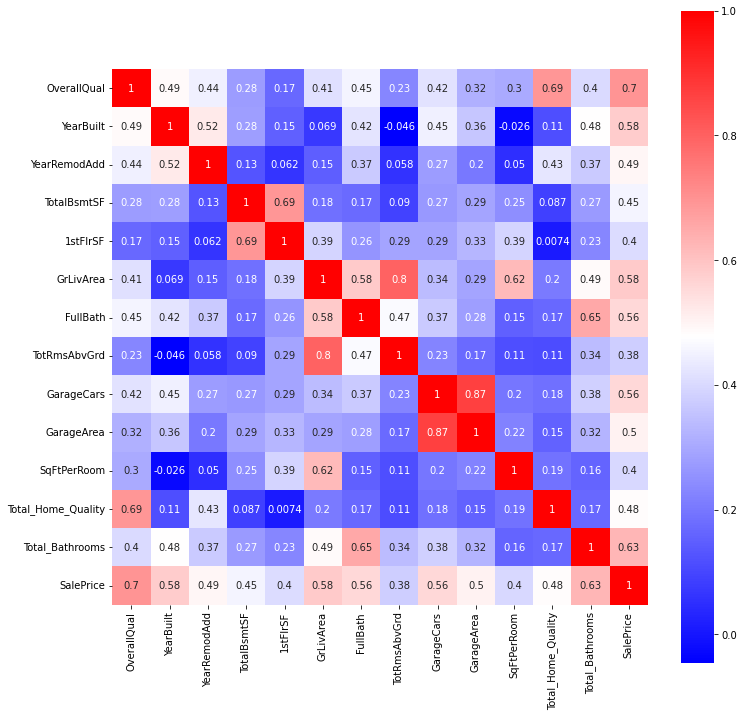

In [28]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat2,square=True,cmap="bwr",annot=True )

## MODEL BUILDING

In [30]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split
x_train = df_train3.drop("SalePrice", axis=1)
y_train = df_train3["SalePrice"] 

In [38]:
# Test split the data 
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size = 0.1,random_state=42)

In [34]:
# Creation of the RMSE metric: 
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [35]:
y_train

1219     91500
64      219500
246     137000
1400    120000
434      81000
         ...  
1124    163900
1160    146000
1330    227000
886     145000
1156    179900
Name: SalePrice, Length: 1042, dtype: int64

In [40]:
from lightgbm import LGBMRegressor

model_lgb = LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)
model_lgb.fit(x_train, y_train)

y_pred_lgb = model_lgb.predict(x_valid)

#xgb_pred = xgb_model.predict(x_test)
score = rmse((y_valid), (y_pred_lgb))
score 

15532.431260808164

In [42]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_valid, y_pred_lgb) 

0.01369607108306662

In [43]:
xgb = XGBRegressor()
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(x_train,y_train)
predictions = xgb.predict(x_valid) 

#xgb_pred = xgb_model.predict(x_test)
score = rmse (y_valid, predictions)
score

17309.288160369983

In [44]:
mean_squared_log_error(y_valid, predictions)  

0.01784003474386356

**Stacking Model**

In [79]:
# Test split the data 
from sklearn.model_selection import train_test_split 

x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state=42)

x_valid,x_test,y_valid,y_test = train_test_split(x_valid,y_valid,test_size = 0.5,random_state=42)
# checking the shapes of datasets

In [80]:
# checking the shapes of datasets
print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_valid :", x_valid.shape)
print("Shape of y_valid :", y_valid.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (1168, 73)
Shape of y_train : (1168,)
Shape of x_valid : (146, 73)
Shape of y_valid : (146,)
Shape of x_test : (146, 73)
Shape of y_test : (146,)


In [81]:
from lightgbm import LGBMRegressor
model1= LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)
# Cat Boost Regressor
from catboost import CatBoostRegressor
model2 = CatBoostRegressor()

from xgboost import XGBRegressor
model3  = XGBRegressor()

In [82]:
#training the initial learners
model1.fit(x_train, y_train)
model2.fit(x_train,y_train,
                     eval_set = (x_valid,y_valid),
                     plot=True,
                     verbose = 0)
model3.fit(x_train,y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [60]:
#making predictions for the validation data
preds1 = model1.predict(x_valid)
preds2 = model2.predict(x_valid) 
preds3 = model3.predict(x_valid)

#making predictions for the test data
test_preds1 = model1.predict(x_test)
test_preds2 = model2.predict(x_test)
test_preds3 = model3.predict(x_test)

In [61]:
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((preds1,preds2,preds3))

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((test_preds1,test_preds2,test_preds3)) 

In [62]:
final_model= LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)

#training the final model on the stacked predictions
final_model.fit(train_stack,y_valid)

LGBMRegressor(colsample_bytree=0.9497036, learning_rate=0.03, max_depth=8,
              min_child_weight=40, min_split_gain=0.0222415, n_estimators=200,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.8715623)

In [63]:
final_predictions = final_model.predict(test_stack) 

#xgb_pred = xgb_model.predict(x_test)
score = rmse(y_test, final_predictions)
score

22966.31975036576

## SUBMISSION

In [ ]:
result=pd.DataFrame(df_test["Id"])
result["SalePrice"]=y_pred2
result.set_index("Id",inplace=True)
result

In [ ]:
result.to_csv("submission.csv")